This notebook is inspired from this video, all the data and steps followed in the turorial can be found here.

https://www.youtube.com/watch?v=jxuNLH5dXCs&ab_channel=StatQuestwithJoshStarmer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# df = pd.read_csv("https://raw.githubusercontent.com/nunnarilabs/ml/master/heart.csv")

# intialise data of lists. 
data = {'popcorn':[1,1,0,1,0,0], 
        'age':[12,87,44,19,32,14],
       'color':[0,1,0,2,1,0],
       'op':[1,1,0,0,1,1]} 
  
# Create DataFrame 
df = pd.DataFrame(data) 

In [3]:
df.head()

,popcorn,age,color,op
0,1,12,0,1
1,1,87,1,1
2,0,44,0,0
3,1,19,2,0
4,0,32,1,1


In [4]:
df.describe()

,popcorn,age,color,op
count,6.000000,6.000000,6.000000,6.000000
mean,0.500000,34.666667,0.666667,0.666667
std,0.547723,28.352543,0.816497,0.516398
min,0.000000,12.000000,0.000000,0.000000
25%,0.000000,15.250000,0.000000,0.250000
50%,0.500000,25.500000,0.500000,1.000000
75%,1.000000,41.000000,1.000000,1.000000
max,1.000000,87.000000,2.000000,1.000000


## Initial Prediction

In [5]:
df.op.value_counts()

1    4
0    2
Name: op, dtype: int64

*log(odds)*

*log(yes/no)*

In [6]:
# initial prediction
log_of_odds = np.log(df.op.value_counts()[1]/ df.op.value_counts()[0])
print(log_of_odds)

0.6931471805599453


The easiest way to use the log(odds) for classification is to convert it to a probability. To do so, we'll use this formula:

![](https://blog.paperspace.com/content/images/2019/11/image-8.png)

In [7]:
probability = np.exp(log_of_odds)/(1+np.exp(log_of_odds))
print(probability)

0.6666666666666666


In [8]:
y_hat = np.array([probability]*6)
print(y_hat)

[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]


In [9]:
df['initial_pred'] = y_hat

In [10]:
df

,popcorn,age,color,op,initial_pred
0,1,12,0,1,0.666667
1,1,87,1,1,0.666667
2,0,44,0,0,0.666667
3,1,19,2,0,0.666667
4,0,32,1,1,0.666667
5,0,14,0,1,0.666667


Since the Probability of Loving Troll 2 is greater than 0.5, we can Classify everyone in the Training Dataset as someone who Loves Troll 2. 

(0.5 is a common threshold used for classification decisions made based on probability; note that the threshold can easily be taken as something else.)



## Calculate Pseudo-Residuals

![](https://blog.paperspace.com/content/images/2019/11/image-9.png)

In [11]:
y = df.op
residuals = y - y_hat
residuals

0    0.333333
1    0.333333
2   -0.666667
3   -0.666667
4    0.333333
5    0.333333
Name: op, dtype: float64

## Build a tree to predict residuals

We will use this residual to get the next tree. It may seem absurd that we are considering the residual instead of the actual value, but you will se how it is done.

In [12]:
X = df.drop('op', axis=1)

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
regressor = DecisionTreeRegressor(max_depth=2) 
regressor.fit(X, residuals)

DecisionTreeRegressor(max_depth=2)

In [14]:
text_representation = tree.export_text(regressor)
print(text_representation)

|--- feature_2 <= 1.50
|   |--- feature_1 <= 38.00
|   |   |--- value: [0.33]
|   |--- feature_1 >  38.00
|   |   |--- value: [-0.17]
|--- feature_2 >  1.50
|   |--- value: [-0.67]



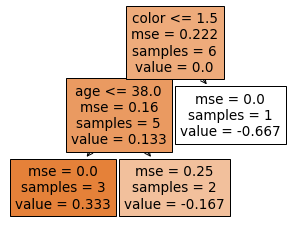

In [15]:
fig = plt.figure(figsize=(5,4))
_ = tree.plot_tree(regressor, feature_names=df.columns, filled=True)

When we used Gradient Boost for Regression, a leaf with single Residual had an Output Value equal to that Residual.

In contrast, when we use Gradient Boost for Classification, the situation is a little more complex. This is because the predictions are in terms of **log(odds)**





When we use Gradient Boost for Classification, the most common transformation is the following formula.

![](https://blog.paperspace.com/content/images/2019/11/image-10.png)

In [16]:
reg_pred_tree1 = regressor.predict(X)/(y_hat * (1 - y_hat))
reg_pred_tree1

array([ 1.5 , -0.75, -0.75, -3.  ,  1.5 ,  1.5 ])

In [17]:
# Explanation for previous expression
regressor.predict(X)

array([ 0.33333333, -0.16666667, -0.16666667, -0.66666667,  0.33333333,
        0.33333333])

In [18]:
# Explanation for previous expression
(y_hat * (1 - y_hat))

array([0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222,
       0.22222222])

Now that we have transformed it, we can add our initial lead with our new tree with a learning rate.

![](https://blog.paperspace.com/content/images/2019/11/image-14.png)

In [19]:
# usually learning rate will be 0.1
lr = 0.8
log_of_odds_prediction = y_hat + 0.8 * reg_pred_tree1
log_of_odds_prediction

array([ 1.86666667,  0.06666667,  0.06666667, -1.73333333,  1.86666667,
        1.86666667])

### Convert to Probability

In [20]:
def prob(pred):
    return np.exp(pred)/ (1+ np.exp(pred))

In [21]:
prob(1.8)

0.8581489350995122

In [22]:
vectorized_func = np.vectorize(prob)

In [23]:
after_tree1 = vectorized_func(log_of_odds_prediction)
after_tree1

array([0.86607211, 0.5166605 , 0.5166605 , 0.15016171, 0.86607211,
       0.86607211])

In [24]:
df['pred_prob'] = after_tree1

In [25]:
df

,popcorn,age,color,op,initial_pred,pred_prob
0,1,12,0,1,0.666667,0.866072
1,1,87,1,1,0.666667,0.516660
2,0,44,0,0,0.666667,0.516660
3,1,19,2,0,0.666667,0.150162
4,0,32,1,1,0.666667,0.866072
5,0,14,0,1,0.666667,0.866072


There is an improvement in the prediction.

In [26]:
def gradient_boost_classification(X,y,M, lr):
    log_of_odds = np.log(y.value_counts()[1]/ y.value_counts()[0])
    probability = np.exp(log_of_odds)/(1+np.exp(log_of_odds))
    y_hat = np.array([probability]*len(y))
    
    for i in range(M):
        # calculate residuals
        residuals = y - y_hat
        # fit the tree for residuals
        regressor = DecisionTreeRegressor(max_depth=2) 
        regressor.fit(X, residuals)
        # Transformation
        reg_pred = regressor.predict(X)/(y_hat * (1 - y_hat))
        # Add the result to previous tree op
        log_of_odds_prediction = y_hat + lr * reg_pred
        new_prob = vectorized_func(log_of_odds_prediction)
        y_hat = new_prob
        
    return y_hat


    

In [27]:
gradient_boost_classification(X, df.op, 10, 0.8)

array([0.77861356, 0.87302675, 0.25109557, 0.62403678, 0.77861356,
       0.77861356])

In [28]:
gradient_boost_classification(X, df.op, 8, 0.8)

array([0.77874274, 0.87315709, 0.2512179 , 0.62423136, 0.77874274,
       0.77874274])